# Opening Files and Plotting Data

In [1]:
import awkward as ak
import numpy as np
import coffea
import uproot
import hist
import vector
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from dask.distributed import Client
import matplotlib.pyplot as plt

### Data Analysis with Plain Uproot

The ROOT files to be analyzed are in the text files located in the `data` folder. The `DYJets...` files contain the MC generated data, while the `EGamma...`, `SingleElectron...`, and `SingleMuon...` files have the reconstructed data. Lets look at some of these. To begin with, let's look at a MC ROOT file and open it with nothng but Uproot. The documentation for this library can be found here [**(Uproot)**](https://uproot.readthedocs.io/en/latest/index.html#). 

In [2]:
#gen_file = uproot.open("skhep_testdata/data/nanoAOD_2015_CMS_Open_Data_ttbar.root")
#gen_file = uproot.open("root://xcache//store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/260000/18D0A087-30BD-FE4E-B447-5F493C2D2794.root")
gen_file = uproot.open("root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/260000/18D0A087-30BD-FE4E-B447-5F493C2D2794.root")
gen_file

<ReadOnlyDirectory '/' at 0x7f10bc839340>

Note that when working in Coffea-casa the redirector is `root://xcache/` while when working on the LPC it would be `root://cmsxrootd.fnal.gov/`. Once our data is loaded, we have a tree object that has the features of a Python dictionary. Its keys are:

In [3]:
gen_file.keys()

['tag;1',
 'Events;1',
 'LuminosityBlocks;1',
 'Runs;1',
 'MetaData;1',
 'ParameterSets;1']

Using the `classname()` method we see that our file has multiple trees. Let's examine the branches of `Events`:

In [4]:
gen_file.classnames()

{'tag;1': 'TObjString',
 'Events;1': 'TTree',
 'LuminosityBlocks;1': 'TTree',
 'Runs;1': 'TTree',
 'MetaData;1': 'TTree',
 'ParameterSets;1': 'TTree'}

In [5]:
gen_tree = gen_file["Events"]
gen_tree

<TTree 'Events' (1504 branches) at 0x7f10bc852490>

In [6]:
gen_tree.num_entries

57804

A convenient method to use is `show()`, which gives all the keys in `mc_tree` plus extra information. However, since there are 1504 keys (i.e. branches), we should filter them to clear up our analysis. Some filters we can use are `filter_name`, `filter_typename`, and `filter_branch`. Let's filter with the former:

In [7]:
gen_tree.show(filter_name=["/(Electron|Muon)_pt/", "/(Electron|Muon)_phi/", "/(Electron|Muon)_eta/", "/(Electron|Muon)_mass/", "/(Electron|Muon)_charge/"])

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Electron_eta         | float[]                  | AsJagged(AsDtype('>f4'))
Electron_mass        | float[]                  | AsJagged(AsDtype('>f4'))
Electron_phi         | float[]                  | AsJagged(AsDtype('>f4'))
Electron_pt          | float[]                  | AsJagged(AsDtype('>f4'))
Electron_charge      | int32_t[]                | AsJagged(AsDtype('>i4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_ptErr           | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))


The `arrays()` method returns a group of arrays from the tree branches. We can use it to construct the kinematics of the electron and muon: 

In [8]:
gen_electron_kinematics = gen_tree.arrays(["Electron_pt", "Electron_phi", "Electron_eta", "Electron_mass", "Electron_charge"])
gen_muon_kinematics = gen_tree.arrays(["Muon_pt", "Muon_phi", "Muon_eta", "Muon_mass", "Muon_charge"])

print(gen_electron_kinematics)
print(gen_muon_kinematics)

[{Electron_pt: [46.4, 11.2], Electron_phi: [-1.73, ... Electron_charge: [-1]}]
[{Muon_pt: [], Muon_phi: [], Muon_eta: [], ... Muon_mass: [], Muon_charge: []}]


Now we can use Awkward to perform some analysis. For example, we can check to see that the number of subarrays in the electron and muon branches are equal; we can also check the total number of electrons and muons in each branch. Documentation for this library can be found here [**(Awkward)**](https://awkward-array.org/doc/main/index.html).

In [9]:
print(f"Subarrays in electron branch: {ak.num(gen_electron_kinematics.Electron_pt, axis=0)}")
print(f"Subarrays in muon branch: {ak.num(gen_muon_kinematics.Muon_pt, axis=0)}")

Subarrays in electron branch: 57804
Subarrays in muon branch: 57804


In [10]:
print(f"Total number of electrons: {ak.sum(ak.num(gen_electron_kinematics.Electron_pt, axis=-1))}")
print(f"Total number of muons: {ak.sum(ak.num(gen_muon_kinematics.Muon_pt, axis=-1))}")

Total number of electrons: 55659
Total number of muons: 43850


We can also see the first few subarrays of each brach using slice notation, where the number of elements in each subarray will be the number of particles.

In [11]:
gen_electron_kinematics[:3].to_list()

[{'Electron_pt': [46.35100555419922, 11.204719543457031],
  'Electron_phi': [-1.73193359375, 1.875244140625],
  'Electron_eta': [0.6239013671875, 1.4326171875],
  'Electron_mass': [-0.01036834716796875, 0.003875732421875],
  'Electron_charge': [-1, -1]},
 {'Electron_pt': [96.58295440673828, 11.642792701721191],
  'Electron_phi': [1.446044921875, -2.50537109375],
  'Electron_eta': [0.4996337890625, 2.31201171875],
  'Electron_mass': [-0.034637451171875, -0.01274871826171875],
  'Electron_charge': [-1, 1]},
 {'Electron_pt': [8.170220375061035],
  'Electron_phi': [-0.970458984375],
  'Electron_eta': [2.1767578125],
  'Electron_mass': [0.0135498046875],
  'Electron_charge': [-1]}]

In [12]:
gen_electron_kinematics.Electron_pt[:3].to_list()

[[46.35100555419922, 11.204719543457031],
 [96.58295440673828, 11.642792701721191],
 [8.170220375061035]]

Finally, we can start creating histograms with our data using the Hist library whose documentation can be found here [**(Hist)**](https://hist.readthedocs.io/en/latest/index.html). Let's first define our axes for binning, create instances of some histograms, fill these histograms wiht our data, and then plot the histograms:

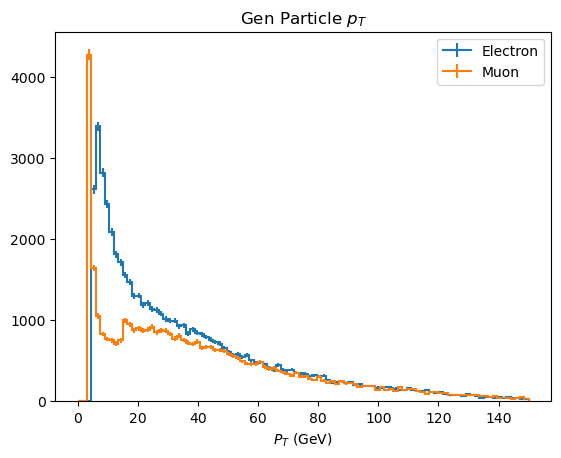

In [13]:
lepton_cat = hist.axis.StrCategory(categories=["Electron", "Muon"], name="lepton")
lepton_pt_axis = hist.axis.Regular(100, 0, 150, name="lepton_pt")

gen_pt_hist = hist.Hist(lepton_cat, lepton_pt_axis)

gen_pt_hist.fill(lepton_pt=ak.flatten(gen_electron_kinematics.Electron_pt), lepton="Electron")
gen_pt_hist.fill(lepton_pt=ak.flatten(gen_muon_kinematics.Muon_pt), lepton="Muon")

gen_pt_hist.plot()
plt.title("Gen Particle $p_{T}$")
plt.xlabel("$P_{T}$ (GeV)")
plt.legend();

For completeness, lets also plot histograms from our reconstructed electron and muon files using the same algorithm we have been using.

In [14]:
#reco_electron_file = uproot.open("root://xcache//store/data/Run2016F/SingleElectron/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/130000/31BADB98-BCD8-4B40-9825-7709B08299BD.root")
#reco_muon_file = uproot.open("root://xcache//store/data/Run2016F/SingleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/130000/FF9B5EE5-4C8E-3F41-B608-AC8DD47E51F2.root")

reco_electron_file = uproot.open("root://cmsxrootd.fnal.gov//store/data/Run2016F/SingleElectron/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/130000/31BADB98-BCD8-4B40-9825-7709B08299BD.root")
reco_muon_file = uproot.open("root://cmsxrootd.fnal.gov//store/data/Run2016F/SingleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/130000/FF9B5EE5-4C8E-3F41-B608-AC8DD47E51F2.root")

reco_electron_tree = reco_electron_file["Events"]
reco_muon_tree = reco_muon_file["Events"]

reco_electron_kinematics = reco_electron_tree.arrays(["Electron_pt", "Electron_phi", "Electron_eta", "Electron_mass", "Electron_charge"])
reco_muon_kinematics = reco_muon_tree.arrays(["Muon_pt", "Muon_phi", "Muon_eta", "Muon_mass", "Muon_charge"])

Although `reco_electron_tree` and `reco_muon_tree` each contain both electron ***and*** muon branches, we will only plot each tree's respective particle species.

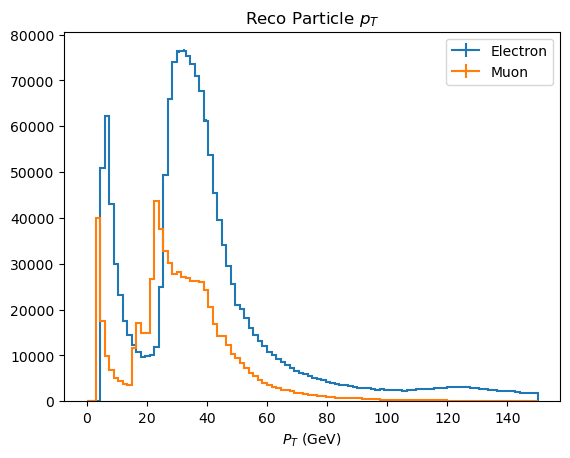

In [15]:
lepton_cat = hist.axis.StrCategory(categories=["Electron", "Muon"], name="lepton")
lepton_pt_axis = hist.axis.Regular(100, 0, 150, name="lepton_pt")

reco_pt_hist = hist.Hist(lepton_cat, lepton_pt_axis)

reco_pt_hist.fill(lepton_pt=ak.flatten(reco_electron_kinematics.Electron_pt), lepton="Electron")
reco_pt_hist.fill(lepton_pt=ak.flatten(reco_muon_kinematics.Muon_pt), lepton="Muon")

reco_pt_hist.plot()
plt.title("Reco Particle $p_{T}$")
plt.xlabel("$P_{T}$ (GeV)")
plt.legend();

### Data Analysis with Uproot Browser

We can also explore ROOT files through a terminal-based browser that provides an interface simiar to a GUI (i.e. a TUI based on text). When working on Coffea-casa, this means that we must install a package through pip on the terminal as [explained here](https://coffea-casa.readthedocs.io/en/latest/cc_packages.html). Documentaion for this browser can be found here [**(Uproot Browser)**](https://github.com/scikit-hep/uproot-browser.git). We must therefore use `pip install uproot-browser` to install the package.
<br><br>
In order to open and examine a ROOT file, we use the command `uproot-browser browse path/to/file.root` on the terminal. We can test this on the files in `skhep_testdata/data/`, however at the present we are unable to open our MC and Reco files through this method; plan to resolve this issue in the future.

### Data Analysis with NanoEvents

As we have seen, ROOT files have many redundant branches that can muddy up the analysis. For example, when we run `mc_file.show()` we see that there are multiple branches for `Electron_*` and `Muon_*`, and Uproot treats all these branches differently. NanoEvents is a Coffea utility that helps standardize files according to a chosen schema; the `BaseSchema` schema thus acts the same as default lazy Uproot. Documentation for Coffea can be found here [**(Coffea)**](https://coffea-casa.readthedocs.io/en/latest/).
<br>
<br>
For our purposes, we will use `NanoAODSchema` which essentially gathers all electron and muon branches into ***collections*** endowed with Lorentz vector methods from the Vector library, whose documentation can be found here [**(Vector)**](https://vector.readthedocs.io/en/latest/). Let's construct our events with `NanoEventsFactory.from_root()`:

In [16]:
#gen_file = "skhep_testdata/data/nanoAOD_2015_CMS_Open_Data_ttbar.root"
#gen_file = "root://xcache//store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/260000/18D0A087-30BD-FE4E-B447-5F493C2D2794.root"
gen_file = "root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/260000/18D0A087-30BD-FE4E-B447-5F493C2D2794.root"
gen_events = NanoEventsFactory.from_root(gen_file, schemaclass=NanoAODSchema).events()

Now that we have a NanoEvent the syntax for accessing its contents is different from plain Uproot, although it still acts as a Python dictionary. For example, instead of the `keys()` method, we use `fields`:

In [17]:
gen_events.fields

['SubJet',
 'SoftActivityJetHT10',
 'FsrPhoton',
 'btagWeight',
 'genWeight',
 'L1simulation',
 'PV',
 'Muon',
 'Pileup',
 'LHEPdfWeight',
 'RawPuppiMET',
 'DeepMETResponseTune',
 'PSWeight',
 'fixedGridRhoFastjetCentral',
 'GenJet',
 'GenPart',
 'CaloMET',
 'ChsMET',
 'GenVisTau',
 'run',
 'FatJet',
 'SoftActivityJet',
 'IsoTrack',
 'DeepMETResolutionTune',
 'LHEPart',
 'GenVtx',
 'SoftActivityJetHT2',
 'SoftActivityJetHT5',
 'PuppiMET',
 'Generator',
 'LHEScaleWeight',
 'HLT',
 'GenIsolatedPhoton',
 'MET',
 'Flag',
 'LHE',
 'LowPtElectron',
 'L1PreFiringWeight',
 'fixedGridRhoFastjetAll',
 'Tau',
 'TrigObj',
 'Photon',
 'HTXS',
 'TkMET',
 'SoftActivityJetHT',
 'SV',
 'fixedGridRhoFastjetCentralCalo',
 'L1Reco',
 'luminosityBlock',
 'SubGenJetAK8',
 'HLTriggerFinalPath',
 'Electron',
 'genTtbarId',
 'fixedGridRhoFastjetCentralNeutral',
 'HLTriggerFirstPath',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'SoftActivityJetNjets5',
 'event',
 'GenJetAK8',
 'GenMET',
 'LHEWeight',
 'CorrT1M

The electron and muon collections can also be queried with `fields`:

In [18]:
electrons = gen_events.Electron
muons = gen_events.Muon
print(f'{electrons.fields}\n\n{muons.fields}')

['dEscaleDown', 'dEscaleUp', 'dEsigmaDown', 'dEsigmaUp', 'deltaEtaSC', 'dr03EcalRecHitSumEt', 'dr03HcalDepth1TowerSumEt', 'dr03TkSumPt', 'dr03TkSumPtHEEP', 'dxy', 'dxyErr', 'dz', 'dzErr', 'eCorr', 'eInvMinusPInv', 'energyErr', 'eta', 'hoe', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniPFRelIso_chg', 'mvaFall17V2Iso', 'mvaFall17V2noIso', 'pfRelIso03_all', 'pfRelIso03_chg', 'phi', 'pt', 'r9', 'scEtOverPt', 'sieie', 'sip3d', 'mvaTTH', 'charge', 'cutBased', 'jetIdx', 'pdgId', 'photonIdx', 'tightCharge', 'vidNestedWPBitmap', 'vidNestedWPBitmapHEEP', 'convVeto', 'cutBased_HEEP', 'isPFcand', 'jetNDauCharged', 'lostHits', 'mvaFall17V2Iso_WP80', 'mvaFall17V2Iso_WP90', 'mvaFall17V2Iso_WPL', 'mvaFall17V2noIso_WP80', 'mvaFall17V2noIso_WP90', 'mvaFall17V2noIso_WPL', 'seedGain', 'genPartIdx', 'genPartFlav', 'cleanmask', 'genPartIdxG', 'jetIdxG', 'photonIdxG']

['dxy', 'dxyErr', 'dxybs', 'dz', 'dzErr', 'eta', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniP

The preferred method of constructing vector objects is through the Vector library, which shares many similarities with the Awkward library. Once constructed, vector methods can be called to obtain new variables.

In [19]:
electron_kinematics = vector.zip({
    "pt": electrons.pt,
    "phi": electrons.phi,
    "eta": electrons.eta,
    "mass": electrons.mass,
    "charge": electrons.charge
})

electron_kinematics[:3].to_list()

[[{'rho': 46.35100555419922,
   'phi': -1.73193359375,
   'eta': 0.6239013671875,
   'tau': -0.01036834716796875,
   'charge': -1},
  {'rho': 11.204719543457031,
   'phi': 1.875244140625,
   'eta': 1.4326171875,
   'tau': 0.003875732421875,
   'charge': -1}],
 [{'rho': 96.58295440673828,
   'phi': 1.446044921875,
   'eta': 0.4996337890625,
   'tau': -0.034637451171875,
   'charge': -1},
  {'rho': 11.642792701721191,
   'phi': -2.50537109375,
   'eta': 2.31201171875,
   'tau': -0.01274871826171875,
   'charge': 1}],
 [{'rho': 8.170220375061035,
   'phi': -0.970458984375,
   'eta': 2.1767578125,
   'tau': 0.0135498046875,
   'charge': -1}]]

In [20]:
print(electron_kinematics.pt)
print(electron_kinematics.theta)
print(electron_kinematics.pseudorapidity)

[[46.4, 11.2], [96.6, 11.6], [8.17], [], ... [], [22.7], [6.29], [86.8], [8.23]]
[[0.984, 0.469], [1.09, 0.197], [0.226], [], ... [1.92], [0.236], [2.53], [1.02]]
[[0.624, 1.43], [0.5, 2.31], [2.18], [], ... [-0.358], [2.13], [-1.15], [0.585]]


We can also access these vector methods through the `coffea.nanoevents.methods` module. For example, although `energy` is not present in `electrons.fields`, it can be obtained by calling it. Similarly, we can compute the pseudorapidity $\eta = - \ln{(\tan \theta / 2 )}$, which is now known as `eta`, and the distance $\Delta R = \sqrt{\Delta \eta^{2} + \Delta \phi^{2}}$ between two objects:

In [21]:
electron_energies = electrons.energy
electron_pseudorapidities = electrons.eta
electron_dr = electrons[0][0].delta_r(electrons[0][1])

print(electron_energies)
print(electron_pseudorapidities)
print(electron_dr)

[[55.7, 24.8], [109, 59.3], [36.5], [], [26.7, ... [], [24.1], [26.9], [150], [9.67]]
[[0.624, 1.43], [0.5, 2.31], [2.18], [], ... [-0.358], [2.13], [-1.15], [0.585]]
2.7955389118613985


As can be seen, Awkward indexing works the same as in Numpy so that `electrons[0][0]` will select from the first event the first electron, `electrons[1][0]` will select from the second event the first electron and so on. Mathematical operations on our electrons can then be perfomed:

In [22]:
electron_sum = electrons[0][0] + electrons[0][1]
print(f"x = {electrons.px[0]}\ny = {electrons.py[0]}\nz = {electrons.pz[0]}\nt = {electrons.t[0]}\ncharge = {electrons.charge[0]}\n")
print(electron_sum)

x = [-7.44, -3.36]
y = [-45.8, 10.7]
z = [30.8, 22.1]
t = [55.7, 24.8]
charge = [-1, -1]

{x: -10.8, y: -35.1, z: 53, t: 80.5, charge: -2}


Another feature added by NanoEvents is data cross-referencing, such as linking `jetIdx` or `pdgId` to our electron collection.

In [23]:
print(electrons.jetIdx)
print(electrons.pdgId)

[[0, 4], [0, 5], [1], [], [0], [0], [0], ... [0], [], [0], [], [0], [-1], [0], [-1]]
[[11, 11], [11, -11], [11], [], [-11], ... [-11], [], [-11], [-11], [-11], [11]]


An important tool we need to perform our analysis is the concept of data masking to select or reject elements of an array based on some criteria. The following is an example of a simple mask:

```python
mask = np.array([True, False, True, False, True])
data = np.array(['a', 'b', 'd', 'c', 'e'])
data[mask]

array(['a', 'd', 'e'], dtype='<U1')
```

Our final array is thus composed of only `True` mask elements. We can use this concept on our electron or muon collections to select events with two particles (a particle and anti-particle pair), each with $p_{T}$ above some threshold. 

In [24]:
electron_pt_mask = electrons.pt > 10
muon_pt_mask = muons.pt > 10

electrons = electrons[electron_pt_mask]
muons = muons[muon_pt_mask]

dielectrons = electrons[(ak.num(electrons, axis=1) == 2) & (ak.sum(electrons.charge, axis=1) == 0)]
dimuons = muons[(ak.num(muons, axis=1) == 2) & (ak.sum(muons.charge, axis=1) == 0)]

print(dielectrons)
print(dimuons)

[[Electron, Electron], [Electron, Electron, ... Electron], [Electron, Electron]]
[[Muon, Muon], [Muon, Muon], [Muon, Muon, ... Muon], [Muon, Muon], [Muon, Muon]]


In [25]:
ee_mass = (dielectrons[:, 0] + dielectrons[:, 1]).mass
mumu_mass = (dimuons[:, 0] + dimuons[:, 1]).mass

print(ee_mass)
print(mumu_mass)

[92.9, 47, 197, 89, 90.4, 90.1, 91.4, ... 83.3, 83, 76.4, 0.982, 112, 91.5, 91.1]
[81.5, 84.8, 89.5, 96.7, 90.9, 90.2, 88.5, ... 93.6, 90.4, 86.6, 91.5, 95, 90.9]


Now that we have this flattened array of dilepton masses, we can go ahead and plot their histograms as before:

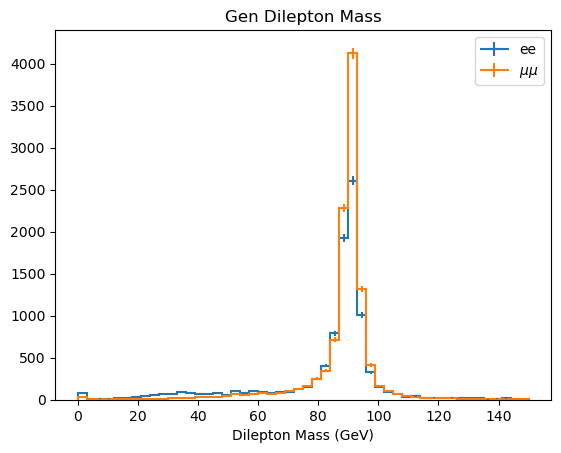

In [26]:
dilepton_cat = hist.axis.StrCategory(categories=["ee", "$\mu\mu$"], name="lepton")
dilepton_mass_axis = hist.axis.Regular(50, 0, 150, name="dilep_mass")

dilepton_mass_hist = hist.Hist(dilepton_cat, dilepton_mass_axis)

dilepton_mass_hist.fill(dilep_mass=ee_mass, lepton="ee")
dilepton_mass_hist.fill(dilep_mass=mumu_mass, lepton="$\mu\mu$")

dilepton_mass_hist.plot()
plt.title("Gen Dilepton Mass")
plt.xlabel("Dilepton Mass (GeV)")
plt.legend();

Lastly, we perform the same analysis on our electron and muon reco files:

In [27]:
reco_electron_file = "root://cmsxrootd.fnal.gov//store/data/Run2016F/SingleElectron/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/130000/31BADB98-BCD8-4B40-9825-7709B08299BD.root"
reco_muon_file = "root://cmsxrootd.fnal.gov//store/data/Run2016F/SingleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/130000/FF9B5EE5-4C8E-3F41-B608-AC8DD47E51F2.root"

reco_electron_events = NanoEventsFactory.from_root(reco_electron_file, schemaclass=NanoAODSchema).events()
reco_muon_events = NanoEventsFactory.from_root(reco_muon_file, schemaclass=NanoAODSchema).events()

electrons = reco_electron_events.Electron[reco_electron_events.Electron.pt > 10]
muons = reco_muon_events.Muon[reco_muon_events.Muon.pt >10]

dielectrons = electrons[(ak.num(electrons, axis=1) == 2) & (ak.sum(electrons.charge, axis=1) == 0)]
dimuons = muons[(ak.num(muons, axis=1) == 2) & (ak.sum(muons.charge, axis=1) == 0)]

ee_mass = (dielectrons[:, 0] + dielectrons[:, 1]).mass
mumu_mass = (dimuons[:, 0] + dimuons[:, 1]).mass

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


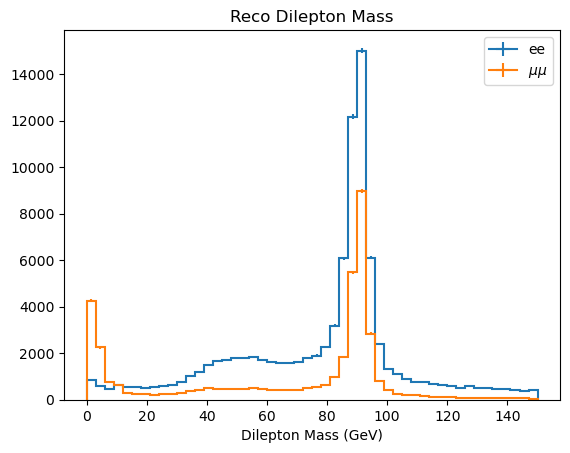

In [28]:
dilepton_cat = hist.axis.StrCategory(categories=["ee", "$\mu\mu$"], name="lepton")
dilepton_mass_axis = hist.axis.Regular(50, 0, 150, name="dilep_mass")

dilepton_mass_hist = hist.Hist(dilepton_cat, dilepton_mass_axis)

dilepton_mass_hist.fill(dilep_mass=ee_mass, lepton="ee")
dilepton_mass_hist.fill(dilep_mass=mumu_mass, lepton="$\mu\mu$")

dilepton_mass_hist.plot()
plt.title("Reco Dilepton Mass")
plt.xlabel("Dilepton Mass (GeV)")
plt.legend();

## Scaling Data Analysis with Coffea

The analysis we've performed so far can be streamlined and made more efficient by utilizing the Coffea processor class. The basic details of this class are summarized as follows:

* `__init__`: Histogram axes and objects are defined here and gatherered in a 
* `accumulator`:
* `process`:
* `postprocess`:



In [29]:
class Processor(processor.ProcessorABC):
    def __init__(self):
        dilepton_cat = hist.axis.StrCategory(categories=["ee", "$\mu\mu$"], name="lepton")
        dilepton_mass_axis = hist.axis.Regular(50, 0, 150, name="dilep_mass")
        
        h_dilepton_mass_gen = hist.Hist(dilepton_cat, dilepton_mass_axis)
        
        cutflow = {}
        
        self.hists = {
            "dilepton_mass_gen":h_dilepton_mass_gen,
            "cutflow":cutflow
        }
        
    @property
    def accumulator(self):
        return self.hists
    
    def process(self, events):
        electrons = events.Electron[events.Electron.pt > 10]
        muons = events.Muon[events.Muon.pt >10]
        
        dielectrons = electrons[(ak.num(electrons, axis=1) == 2) & (ak.sum(electrons.charge, axis=1) == 0)]        
        dimuons = muons[(ak.num(muons, axis=1) == 2) & (ak.sum(muons.charge, axis=1) == 0)]
        
        ee_mass = (dielectrons[:, 0] + dielectrons[:, 1]).mass
        mumu_mass = (dimuons[:, 0] + dimuons[:, 1]).mass
        
        self.hists["dilepton_mass_gen"].fill(dilep_mass=ee_mass, lepton="ee")
        self.hists["dilepton_mass_gen"].fill(dilep_mass=mumu_mass, lepton="$\mu\mu$")
        
        return self.hists
        
    def postprocess(self, accumulator):
        return accumulator

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1288: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+----------------+
| Package | client         | scheduler      | workers        |
+---------+----------------+----------------+----------------+
| python  | 3.8.16.final.0 | 3.8.16.final.0 | 3.8.15.final.0 |
+---------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


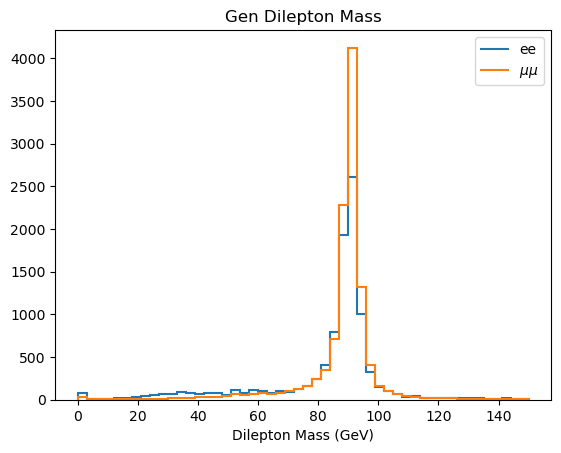

In [30]:
fileset = {
    'mc_file':['root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/260000/18D0A087-30BD-FE4E-B447-5F493C2D2794.root'],
}

client = Client("tls://cebarros-40buffalo-2eedu.dask.cmsaf-prod.flatiron.hollandhpc.org:8786")

run = processor.Runner(executor=processor.DaskExecutor(client=client),
                      schema=NanoAODSchema,
                      chunksize=10000)

output = run(fileset, "Events", processor_instance=Processor())

output["dilepton_mass_gen"].plot()
plt.title("Gen Dilepton Mass")
plt.xlabel("Dilepton Mass (GeV)")
plt.legend();